# SVM One vs Rest Classification

This notebook performs SVM classification using embeddings extracted from the Galaxy10 dataset with a ResNet-101 model pretrained on ImageNet.

We include:
- Grid search for best parameters
- Accuracy, balanced accuracy, precision, recall, F1
- Confusion matrix and per-class report
- Hierarchical class relation analysis

## Imports

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

## PCA on ResNet101 Embeddings

Applies PCA to reduce the dimensionality of the entire dataset using the precomputed ResNet101 embeddings.


In [11]:
# Load data
data = np.load('Galaxy10_Embedding_vectors/galaxy10_resnet101_embeddings_augmented_balanced.npz', allow_pickle=True)

# Separate train, val, and test
X_train = data['train_features']
y_train = data['train_labels']
X_val = data['val_features']
y_val = data['val_labels']
X_test = data['test_features']
y_test = data['test_labels']
class_names = data['class_names']

print(f"Original Train size: {X_train.shape[0]}")
print(f"Original Validation size: {X_val.shape[0]}")
print(f"Original Test size: {X_test.shape[0]}")
print(f"Original Embedding dimension: {X_train.shape[1]}")

# PCA to keep 95% variance (fit only on training data)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(f"Reduced Train dimension: {X_train_pca.shape[1]}")
print(f"Reduced Validation dimension: {X_val_pca.shape[1]}")
print(f"Reduced Test dimension: {X_test_pca.shape[1]}")


Original Train size: 48970
Original Validation size: 3269
Original Test size: 3268
Original Embedding dimension: 2048
Reduced Train dimension: 25
Reduced Validation dimension: 25
Reduced Test dimension: 25


## Grid Search for Optimal Parameters

In [12]:
C_values = [0.1, 1, 10, 50, 100]
gamma_values = ['scale', 'auto']
results = []

for C in C_values:
    for gamma in gamma_values:
        svm = OneVsRestClassifier(SVC(kernel='rbf', C=C, gamma=gamma, random_state=42))
        svm.fit(X_train, y_train)
        y_val_pred = svm.predict(X_val)
        acc = accuracy_score(y_val, y_val_pred)
        results.append({'C': C, 'gamma': gamma, 'accuracy': acc})

results_df = pd.DataFrame(results)

## Plot Accuracy

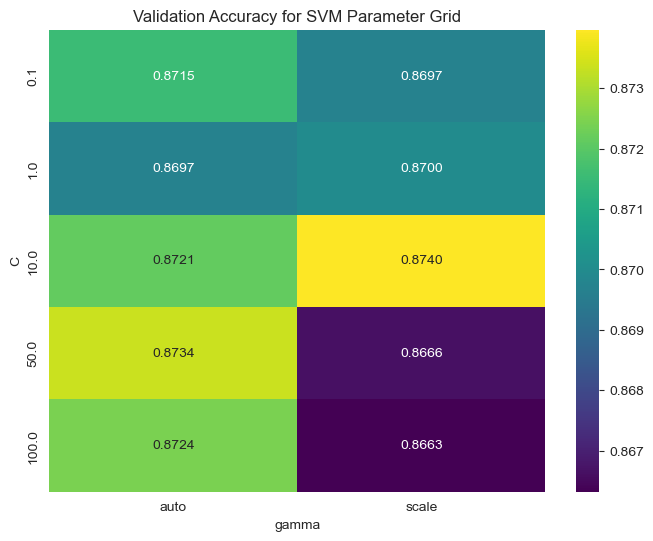

In [13]:
# Plot validation accuracy heatmap
results_pivot = results_df.pivot(index='C', columns='gamma', values='accuracy')
plt.figure(figsize=(8, 6))
sns.heatmap(results_pivot, annot=True, fmt='.4f', cmap='viridis')
plt.title('Validation Accuracy for SVM Parameter Grid')
plt.ylabel('C')
plt.xlabel('gamma')
plt.show()

## Selecting the Best Hyperparameters
This short block locates the grid-search row with the highest validation accuracy, extracts its `C` and `gamma` values, and prints them. These will be used for the final model training.


In [14]:
# Select best hyperparameters
best = results_df.loc[results_df['accuracy'].idxmax()]
best_C = best['C']
best_gamma = best['gamma']
print(f"Best parameters -> C: {best_C}, gamma: {best_gamma}")

Best parameters -> C: 10.0, gamma: scale


## Evaluate SVM on Test Set

Trains the SVM classifier with the best parameters found on the training set, then evaluates it on the test set using accuracy, balanced accuracy, macro precision, recall, and F1 score.

In [15]:
svm_final = OneVsRestClassifier(SVC(kernel='rbf', C=1, gamma='scale', random_state=42))
svm_final.fit(X_train, y_train)
y_pred = svm_final.predict(X_test)

acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f"Accuracy: {acc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1 Score: {f1:.4f}")

Accuracy: 0.8791
Balanced Accuracy: 0.7529
Macro Precision: 0.7710
Macro Recall: 0.7529
Macro F1 Score: 0.7611


## Confusion Matrices

Displays two confusion matrices: one with raw counts and one with row-wise percentages for the test set predictions.


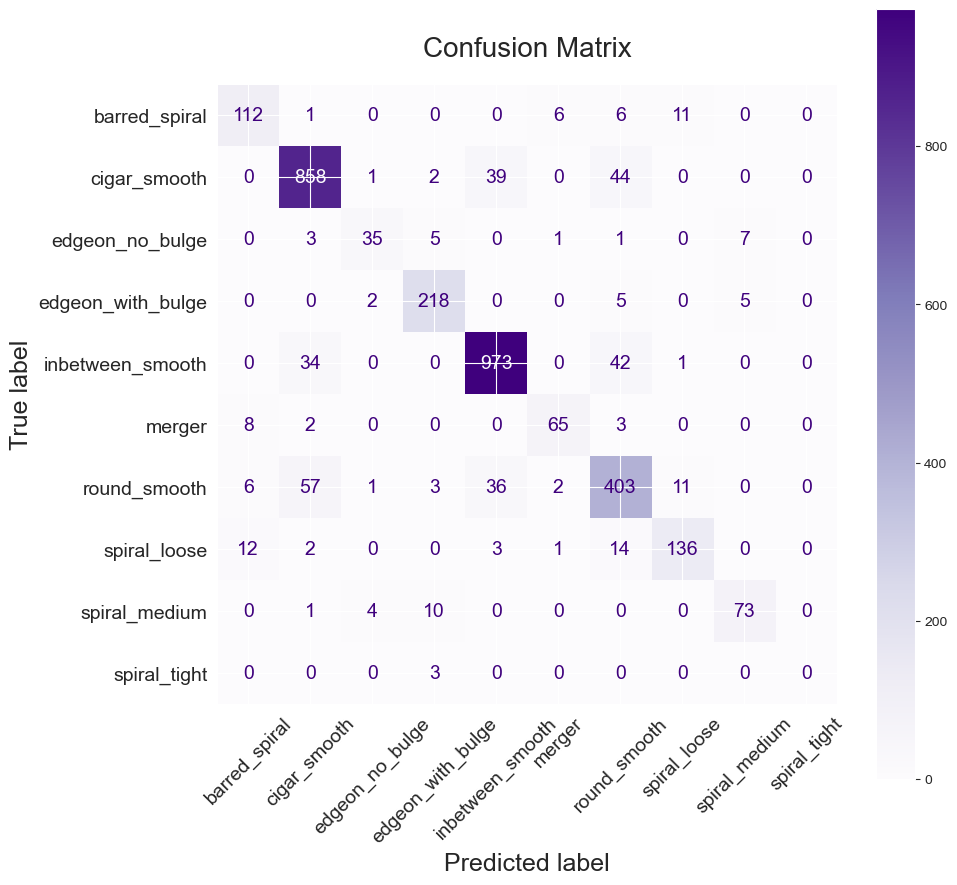

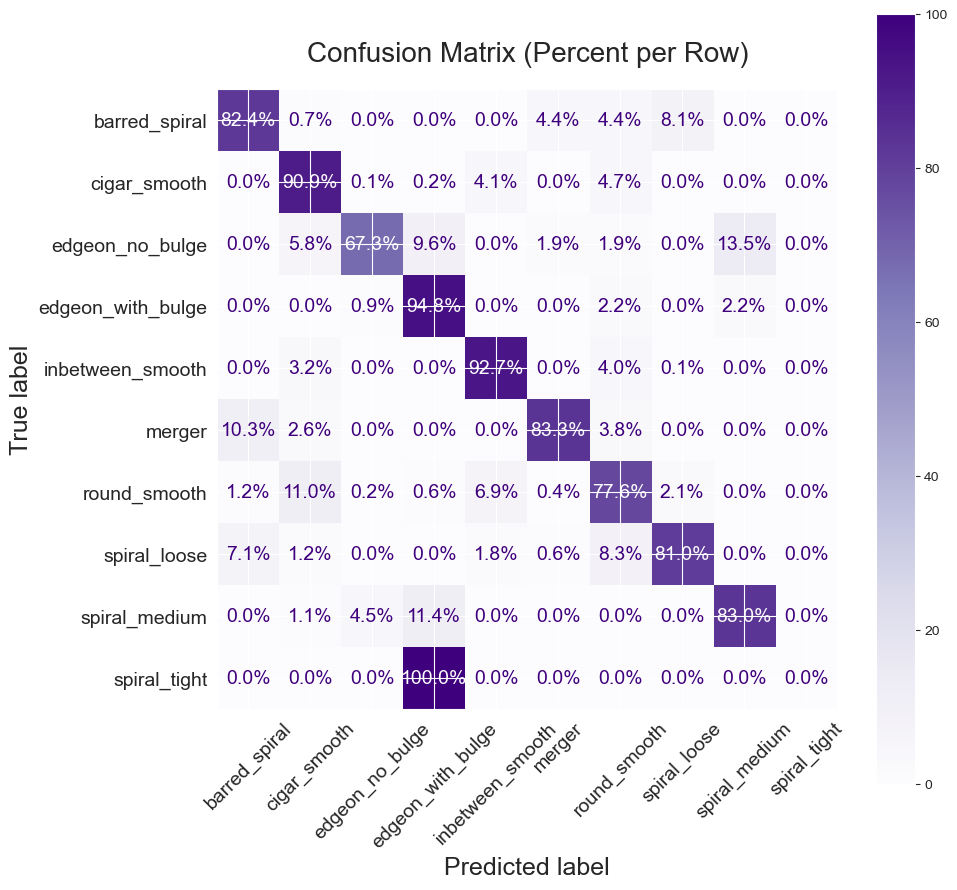

In [16]:
# Confusion matrix (raw counts)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Purples', xticks_rotation=45)

ax.set_title("Confusion Matrix", fontsize=20, pad=20)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.tick_params(axis='both', labelsize=14)
for text in disp.text_.ravel():
    text.set_fontsize(14)

plt.show()

# Confusion matrix (row-wise percentages)
cm_percent = cm.astype(float) / cm.sum(axis=1)[:, None] * 100
disp_percent = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp_percent.plot(ax=ax, cmap='Purples', xticks_rotation=45, values_format='.1f')

for text in disp_percent.text_.ravel():
    text.set_text(f"{float(text.get_text()):.1f}%")
    text.set_fontsize(14)

ax.set_title("Confusion Matrix (Percent per Row)", fontsize=20, pad=20)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.tick_params(axis='both', labelsize=14)

plt.show()

## Classification Report

Prints precision, recall, F1 score, and support for each class in the test set.


In [17]:
print(classification_report(y_test, y_pred, target_names=class_names, digits=4, zero_division=0))

                   precision    recall  f1-score   support

    barred_spiral     0.8116    0.8235    0.8175       136
     cigar_smooth     0.8956    0.9089    0.9022       944
  edgeon_no_bulge     0.8140    0.6731    0.7368        52
edgeon_with_bulge     0.9046    0.9478    0.9257       230
 inbetween_smooth     0.9258    0.9267    0.9262      1050
           merger     0.8667    0.8333    0.8497        78
     round_smooth     0.7780    0.7765    0.7772       519
     spiral_loose     0.8553    0.8095    0.8318       168
    spiral_medium     0.8588    0.8295    0.8439        88
     spiral_tight     0.0000    0.0000    0.0000         3

         accuracy                         0.8791      3268
        macro avg     0.7710    0.7529    0.7611      3268
     weighted avg     0.8779    0.8791    0.8783      3268



## Hierarchical Clustering of Predicted Classes

We analyzed how the model groups Galaxy10 classes by performing hierarchical clustering based on the **mean embedding** (centroid) of each **predicted class** in the test set.

For each class that was actually predicted by the model, we computed its centroid by averaging the embeddings of all test samples assigned to that class. This approach reflects how the model internally organizes its predictions in feature space.

We used **Ward’s method** on the pairwise **Euclidean distances** between class centroids:

$$
\text{Distance}(C_i, C_j) = \left\| \mu_i - \mu_j \right\|_2
$$

This method reveals how semantically close the predicted classes are according to the model’s learned representation.

> Note: Classes not predicted at all are excluded from the dendrogram.

Skipping class spiral_tight: no predictions in test set.


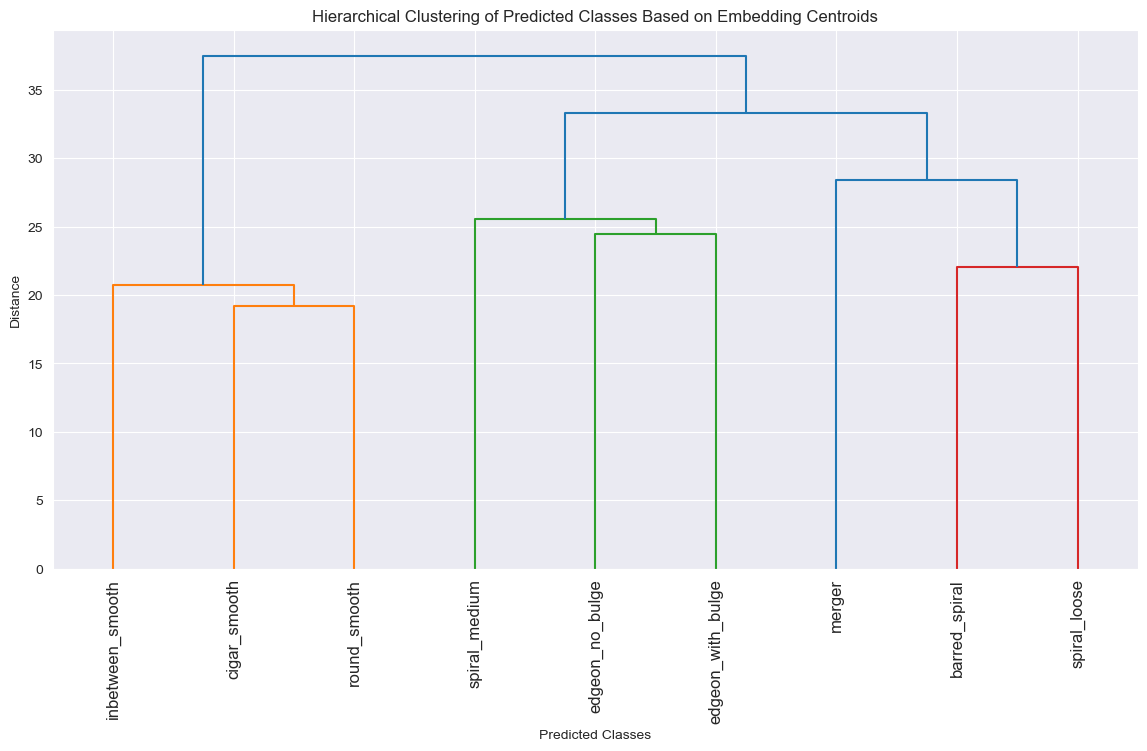

In [18]:
# Make sure class names are a numpy array
class_names = np.array(class_names)

# Find the unique classes predicted by the model
predicted_classes = np.unique(y_pred)

centroids_pred = []
valid_class_names_pred = []

for cls in range(len(class_names)):
    idx = np.where(y_pred == cls)[0]

    if len(idx) == 0:
        print(f"Skipping class {class_names[cls]}: no predictions in test set.")
        continue
    else:
        centroid = np.mean(X_test[idx], axis=0)
        centroids_pred.append(centroid)
        valid_class_names_pred.append(class_names[cls])

centroids_pred = np.array(centroids_pred)
valid_class_names_pred = np.array(valid_class_names_pred)

# Perform hierarchical clustering
linked_pred = linkage(centroids_pred, method='ward')

# Plot dendrogram
plt.figure(figsize=(14, 7))
dendrogram(linked_pred, labels=valid_class_names_pred, leaf_rotation=90)
plt.title('Hierarchical Clustering of Predicted Classes Based on Embedding Centroids')
plt.xlabel('Predicted Classes')
plt.ylabel('Distance')
plt.show()